<a href="https://colab.research.google.com/github/jordanbuddenhagen/Project-2/blob/main/Project_2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

## Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
## Classification Metrics
from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay, 
                             PrecisionRecallDisplay, RocCurveDisplay, 
                             f1_score, accuracy_score, precision_score,
                             recall_score, classification_report)
from sklearn.decomposition import PCA
sns.set()
## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}
from warnings import filterwarnings 
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [49]:
def eval_classification(true, pred, name, labels=None):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""
  
    print(name, '\n')
    print(classification_report(true, pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=labels, cmap='Greens')

    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

# First Choice

In [2]:
filename = '/content/healthcare-dataset-stroke-data[1].csv' 

df_stroke = pd.read_csv(filename)
df_stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
pd.set_option('display.max_rows', None)

In [4]:
df_stroke.drop(columns= [ 'work_type', 'id', 'ever_married'], inplace=True, axis=1)

### Dropping these two columns-- not needed with what I am trying to find.  id- just a person id number.  With childern in the study, I am going to get rid of Marriage and work type.  Both could be skewed in data set.  

In [5]:
df_stroke.duplicated().sum()

0

### There is no duplicates.

In [6]:
df_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   Residence_type     5110 non-null   object 
 5   avg_glucose_level  5110 non-null   float64
 6   bmi                4909 non-null   float64
 7   smoking_status     5110 non-null   object 
 8   stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 359.4+ KB


In [7]:
df_stroke.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

#### BMI we will average out the numbers.  

In [8]:
#df_stroke[df_stroke['bmi'].isna()] 
#Exploring the data of missing BMis

In [9]:
df_stroke.fillna(df_stroke['bmi'].mean(), inplace=True)

In [10]:
df_stroke.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [11]:
df_stroke['bmi'].describe()

count    5110.000000
mean       28.893237
std         7.698018
min        10.300000
25%        23.800000
50%        28.400000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64

In [12]:
df_stroke.shape

(5110, 9)

In [13]:
df_stroke.nunique()

gender                  3
age                   104
hypertension            2
heart_disease           2
Residence_type          2
avg_glucose_level    3979
bmi                   419
smoking_status          4
stroke                  2
dtype: int64

In [14]:
dtypes = df_stroke.dtypes 
str_columns = dtypes[dtypes=='object'].index 
str_columns 

Index(['gender', 'Residence_type', 'smoking_status'], dtype='object')

In [15]:
for col in str_columns: 
  print(f'- Column= {col}') 
  print(df_stroke[col].value_counts(dropna=False))

- Column= gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
- Column= Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
- Column= smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


- Most values look pretty good.  I am going to drop the row with the 'Other' gender.  While there may be that possiblity, it is only one value and is very imbalanced.  

In [16]:
df_stroke_gendother = df_stroke.loc[df_stroke['gender'] == 'Other']  #Finding other value

In [17]:
df_stroke_gendother.head()

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,Rural,143.33,22.4,formerly smoked,0


In [18]:
df_stroke.drop(axis=0, index=3116, inplace=True)

In [19]:
for col in str_columns: 
  print(f'- Column= {col}') 
  print(df_stroke[col].value_counts(dropna=False))

- Column= gender
Female    2994
Male      2115
Name: gender, dtype: int64
- Column= Residence_type
Urban    2596
Rural    2513
Name: Residence_type, dtype: int64
- Column= smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64


In [20]:
df_stroke.shape

(5109, 9)

### 'Other' row is dropped

In [21]:
df_stroke.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,43.229986,0.097475,0.054022,106.140399,28.894508,0.048738
std,22.613575,0.296633,0.226084,45.285004,7.698235,0.215340
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.240000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.880000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## Looking at the data-- there is an outlier in age and bmi  

## There is always a chance at any age a child or adult could have a stroke.  I am going to keep all data in for age.

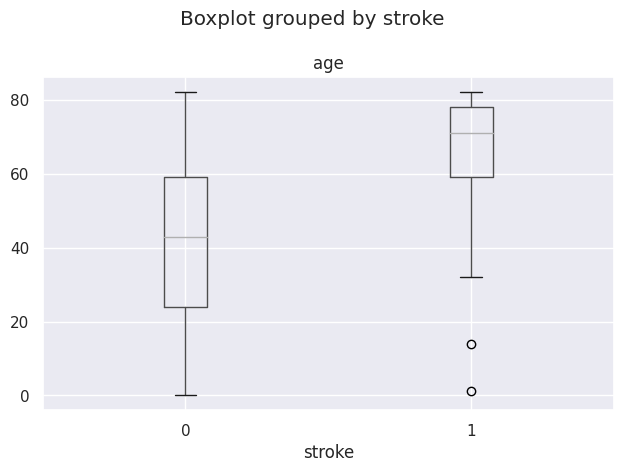

In [22]:
df_stroke.boxplot(column = 'age', by ='stroke') 
plt.tight_layout()

In [ ]:
#df_strokeage = df_stroke['age'].sort_values(ascending=True)
#df_strokeage.head(200)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

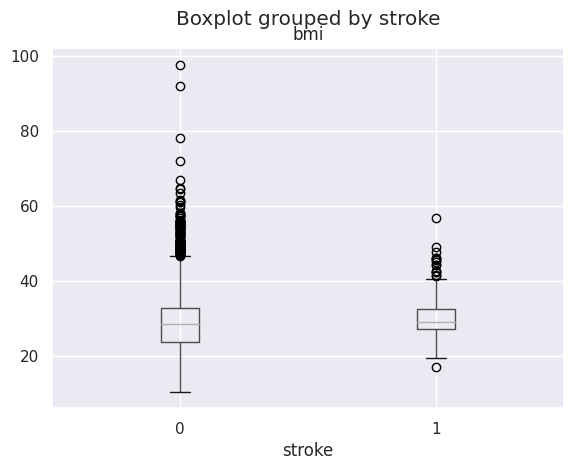

In [23]:
df_stroke.boxplot(column='bmi', by='stroke') 
plt.tight_layout

In [24]:
df_strokebmi = df_stroke['bmi'].sort_values(ascending=False)
df_strokebmi.head(30)

2128    97.6
4209    92.0
928     78.0
544     71.9
1559    66.8
358     64.8
4188    64.4
2764    63.3
3825    61.6
2840    61.2
270     60.9
4838    60.9
466     60.2
3588    59.7
3060    58.1
4351    57.9
1898    57.7
715     57.5
1595    57.3
4475    57.2
4154    57.2
4952    56.6
113     56.6
2081    56.1
1660    56.0
4225    55.9
1584    55.9
662     55.7
2555    55.7
672     55.7
Name: bmi, dtype: float64

# I am going to delete row 2128, 4209, 928 and 544 
- Even 71.9 BMI is 5'10" 500 lbs.  It is possible, but those are extreme cases.  

In [25]:
df_stroke.drop(axis=0, index= [2128, 4209, 928, 544], inplace=True)


In [26]:
df_stroke.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5105 entries, 0 to 5109
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5105 non-null   object 
 1   age                5105 non-null   float64
 2   hypertension       5105 non-null   int64  
 3   heart_disease      5105 non-null   int64  
 4   Residence_type     5105 non-null   object 
 5   avg_glucose_level  5105 non-null   float64
 6   bmi                5105 non-null   float64
 7   smoking_status     5105 non-null   object 
 8   stroke             5105 non-null   int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 398.8+ KB


## Quick plot of Strokes and hypertenstion

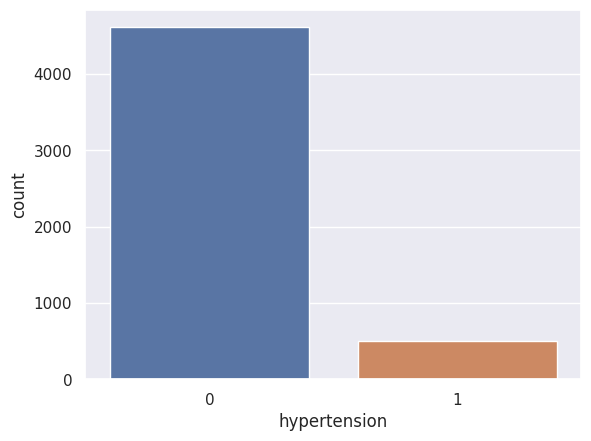

In [27]:
graph_hyper = sns.countplot(data = df_stroke, x='hypertension')

# Heat Map

<ipython-input-28-a24b4de6bb33>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df_stroke.corr()


<Axes: >

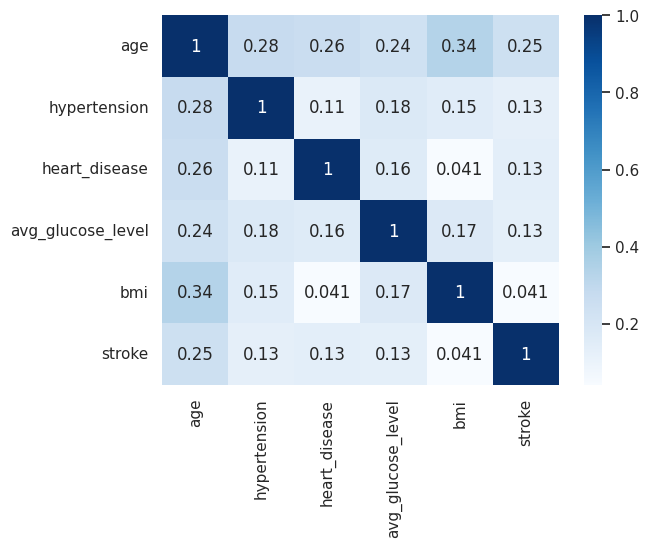

In [28]:
df_corr = df_stroke.corr()
sns.heatmap(data=df_corr, cmap='Blues', annot= True)

# Age and BMI is my highest corrleated data between each other for correlated numeric data, and that is still cosidered a low correlation.  I will have to explore data more to find trends. 

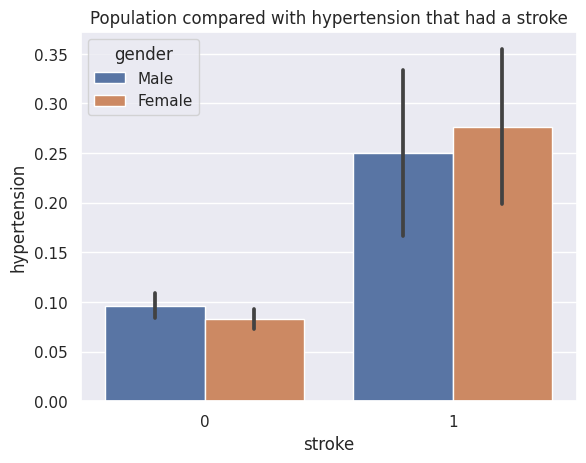

In [29]:
graph_hyperandstrokes = sns.barplot(data=df_stroke, x='stroke', y='hypertension', hue='gender')
graph_hyperandstrokes.set_title('Population compared with hypertension that had a stroke');

- Patients with lower hypertension had fewer strokes. 
- Males and Females were more likely to have a stroke with higher hypertension.

<ipython-input-30-5992f4fb13cc>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_stroke[df_stroke['stroke'] == 1]['age'], hist=False, color="orange").set(title='Average Age of people with Strokes');


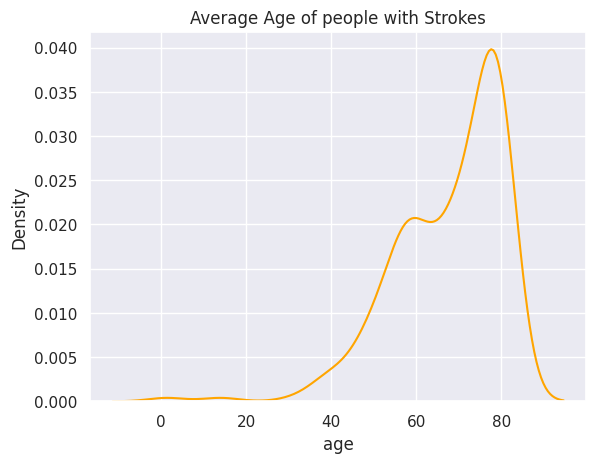

In [30]:
sns.distplot(df_stroke[df_stroke['stroke'] == 1]['age'], hist=False, color="orange").set(title='Average Age of people with Strokes');

plt.show();

## As expected- Age plays a huge factor in who has a stroke.

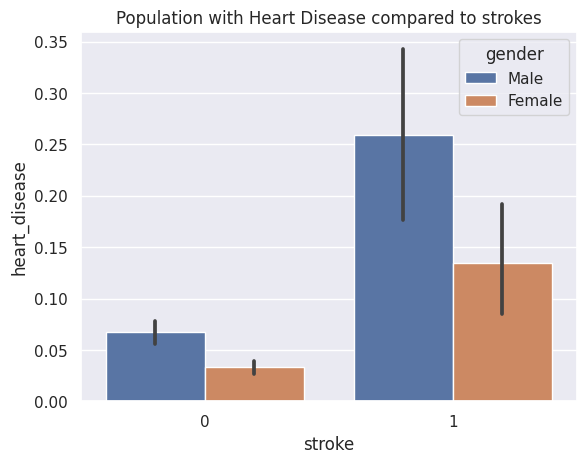

In [31]:
graph_hdandstrokes = sns.barplot(data=df_stroke,x='stroke', y='heart_disease', hue='gender' )
graph_hdandstrokes.set_title('Population with Heart Disease compared to strokes');

## Heart disease was more prevelant in males that had a stroke compared to females. Heart disease is another factor in people that have had a stroke.

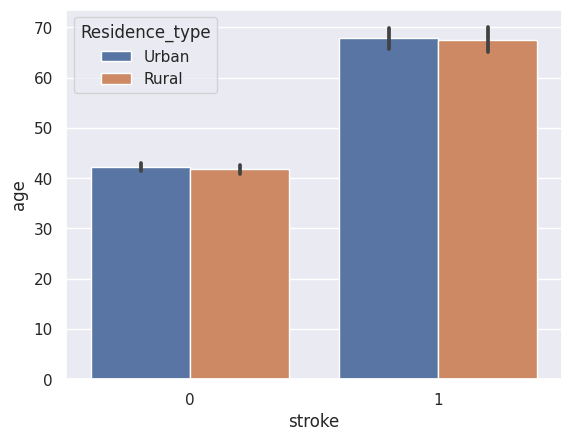

In [32]:
graph_strokes_area = sns.barplot(data=df_stroke, x='stroke', y='age', hue='Residence_type')

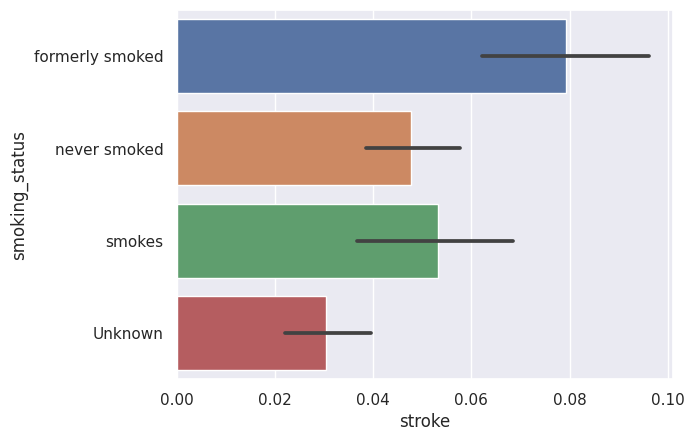

In [33]:
graph_strokes= sns.barplot(data=df_stroke, x='stroke', y='smoking_status')

## Smokers have a higher chance at having a stroke, but it is not a significant amount.  

## In the data, most important factors are heart disease, hypertension and age.  

# Train Test Split 

In [34]:
X = df_stroke.drop(columns = 'stroke', axis=1) 
y = df_stroke['stroke'] 

X.head()

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Urban,228.69,36.600000,formerly smoked
1,Female,61.0,0,0,Rural,202.21,28.893237,never smoked
2,Male,80.0,0,1,Rural,105.92,32.500000,never smoked
3,Female,49.0,0,0,Urban,171.23,34.400000,smokes
4,Female,79.0,1,0,Rural,174.12,24.000000,never smoked


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X , y, random_state=42, test_size=.25) 

In [36]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [37]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False) 
scaler = StandardScaler()

In [38]:
cat_tuple= (ohe, cat_selector)
num_tuple= (scaler, num_selector)

In [39]:
prepro = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')

In [40]:
prepro.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9d7e7f0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9c7fc70>)])

## Fit my preproceser for modeling.

In [41]:
Xtrain_processed= prepro.transform(X_train)    #Transform
Xtest_processed= prepro.transform(X_test)

## Transformed

In [42]:
print(np.isnan(Xtrain_processed).sum().sum(), 'missing values in training data')
print(np.isnan(Xtest_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in Xtrain_processed are', Xtrain_processed.dtype)
print('All data in Xtest_processed are', Xtest_processed.dtype)
print('\n')
print('shape of data is', Xtrain_processed.shape)
print('\n')
Xtrain_processed

0 missing values in training data
0 missing values in testing data


All data in Xtrain_processed are float64
All data in Xtest_processed are float64


shape of data is (3828, 13)




array([[-0.7055103 , -0.32366944, -0.23354968, ...,  0.        ,
         0.        ,  0.        ],
       [-1.10605215, -0.32366944, -0.23354968, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.85215243,  3.0895719 , -0.23354968, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.48298706, -0.32366944, -0.23354968, ...,  0.        ,
         0.        ,  0.        ],
       [-1.0615475 , -0.32366944, -0.23354968, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.25269427, -0.32366944, -0.23354968, ...,  0.        ,
         1.        ,  0.        ]])

## Double checking data.

# Models

## KNeighbors Classifier

In [43]:
knn = KNeighborsClassifier(n_neighbors=2) 

In [44]:
knn_pipe=make_pipeline(prepro, knn)

In [45]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9d7e7f0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9c7fc70>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=2))])

In [46]:
knnpreds_train = knn_pipe.predict(X_train)
knnpreds_test = knn_pipe.predict(X_test)

knn Stroke train 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3659
           1       1.00      0.09      0.16       169

    accuracy                           0.96      3828
   macro avg       0.98      0.54      0.57      3828
weighted avg       0.96      0.96      0.94      3828



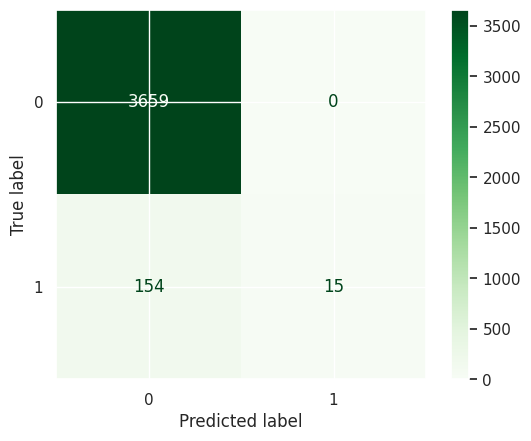

In [50]:
knn_train_scores = eval_classification(y_train, knnpreds_train, name='knn Stroke train')

knn Stroke test 

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1197
           1       0.22      0.03      0.04        80

    accuracy                           0.93      1277
   macro avg       0.58      0.51      0.51      1277
weighted avg       0.89      0.93      0.91      1277



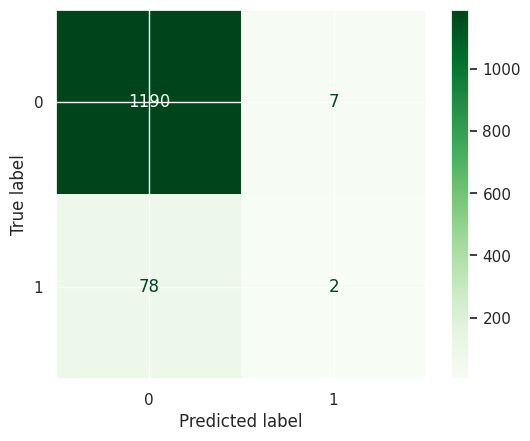

In [51]:
knn_test_scores = eval_classification(y_test, knnpreds_test, name='knn Stroke test')

## The model does really well at predicting people have not had a stroke, however it is not able to predict who may have a stroke due to the small sample size.  It would have a really high accuracy score, but it would have a lot of false negatives.  

## I will use gridsearch to see if I can get a better model.  

In [ ]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fef42306d30>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fef42306f70>)])),
  ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=2))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fef42306d30>),
                                 ('onehotenco

In [52]:
params = {'kneighborsclassifier__n_neighbors': range(1,11),
          'kneighborsclassifier__weights': ['uniform','weighted'],
          'kneighborsclassifier__p': range(1,10)}


In [53]:
knn_gs = GridSearchCV(knn_pipe, params) 
knn_gs.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
450 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py", line 213, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9d7e7f0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9c7fc70>)])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=2))]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 11),
                         'kneighborsclassifier__p': range(1, 10),
                         'kneighborsclassifier__weights': ['uniform',
                                                           'weighted']})

In [54]:
knn_gs.best_params_

{'kneighborsclassifier__n_neighbors': 8,
 'kneighborsclassifier__p': 1,
 'kneighborsclassifier__weights': 'uniform'}

In [55]:
best_knn = knn_gs.best_estimator_

In [56]:
knn_gstrainpreds = best_knn.predict(X_train)
knn_gstestpreds = best_knn.predict(X_test)

Hypertuned Train Knn Model 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3659
           1       0.50      0.01      0.01       169

    accuracy                           0.96      3828
   macro avg       0.73      0.50      0.49      3828
weighted avg       0.94      0.96      0.93      3828



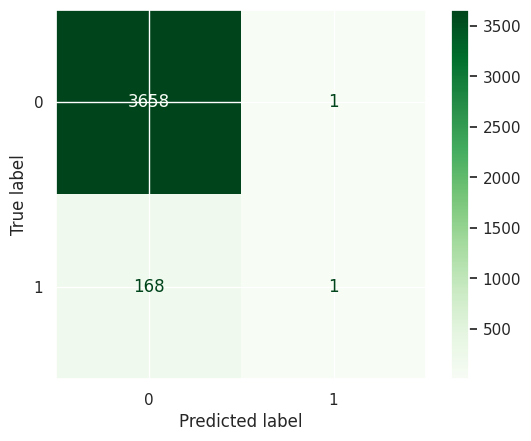

Hypertuned Test KNN Model 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1197
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1277
   macro avg       0.47      0.50      0.48      1277
weighted avg       0.88      0.94      0.91      1277



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


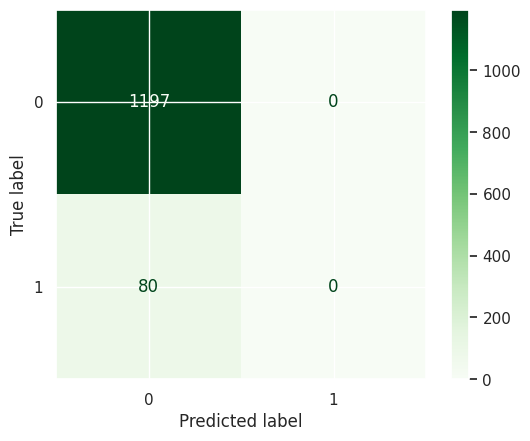

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
tuned_knn_trained_scores = eval_classification(y_train, knn_gstrainpreds, name='Hypertuned Train Knn Model')
tuned_knn_test_scores = eval_classification(y_test, knn_gstestpreds, name='Hypertuned Test KNN Model')

## The accuracy changed slightly, but I would say a worse model with tuned parameters.  My only fear with the other models is that we do not have enough data with people that have had a stroke.  Our model may predict people that have not had a stroke, but it is unable to predict people that may have had one.

# Random Forest Model

In [58]:
rf = RandomForestClassifier()

In [59]:
rf_pipe = make_pipeline(prepro, rf)

In [60]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9d7e7f0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9c7fc70>)])),
                ('randomforestclassifier', RandomForestClassifier())])

In [61]:
rf_trainpreds = rf_pipe.predict(X_train)
rf_testpreds = rf_pipe.predict(X_test)

RF Train Data 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3659
           1       1.00      1.00      1.00       169

    accuracy                           1.00      3828
   macro avg       1.00      1.00      1.00      3828
weighted avg       1.00      1.00      1.00      3828



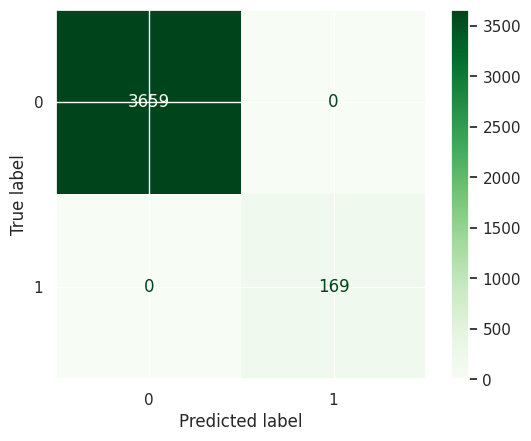

In [62]:
rf_train_scores = eval_classification(y_train, rf_trainpreds , name='RF Train Data')

RF Test Data 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1197
           1       0.33      0.01      0.02        80

    accuracy                           0.94      1277
   macro avg       0.64      0.51      0.50      1277
weighted avg       0.90      0.94      0.91      1277



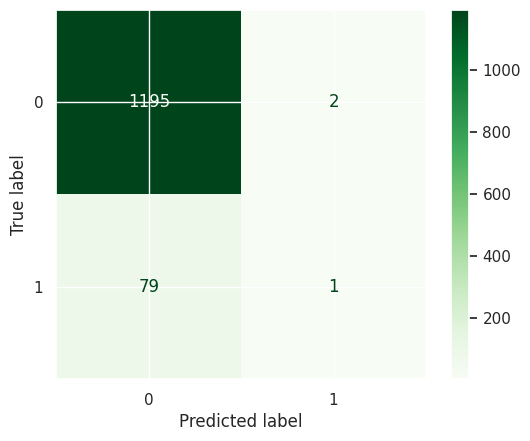

In [63]:
rf_test_scores = eval_classification(y_test, rf_testpreds, name='RF Test Data')

## Random Forest is the same as KNeighbors.  I will fine tune to see if I can find a better model. 

In [64]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9d7e7f0>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9c7fc70>)])),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9d7e7f0>),
                                 ('onehotencoder',
   

In [65]:
rfparams = {'randomforestclassifier__max_depth': [None, 3, 5, 10], 'randomforestclassifier__min_samples_split': np.arange(2,20,2), 'randomforestclassifier__n_estimators': np.arange(10,100,50)}

In [66]:
rf_gs = GridSearchCV(rf_pipe, rfparams, cv=5)

In [67]:
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9d7e7f0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9c7fc70>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': [None, 3, 5, 10],
                         'randomforestclassifier__min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                         'randomforestclassifier__n_estimators': array([10, 60])})

In [68]:
rf_gs.best_params_

{'randomforestclassifier__max_depth': None,
 'randomforestclassifier__min_samples_split': 8,
 'randomforestclassifier__n_estimators': 60}

In [69]:
rf_best = rf_gs.best_estimator_

In [70]:
rf_gstrain_preds = rf_best.predict(X_train)
rf_gstest_preds = rf_best.predict(X_test)

Hypertuned Trained Random Forest 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3659
           1       1.00      0.08      0.14       169

    accuracy                           0.96      3828
   macro avg       0.98      0.54      0.56      3828
weighted avg       0.96      0.96      0.94      3828



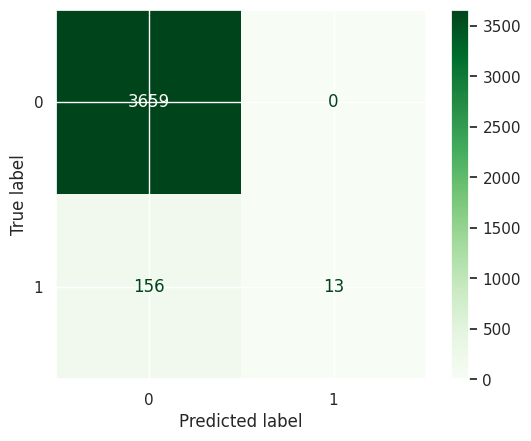

In [71]:
tuned_rftrain_scores = eval_classification(y_train, rf_gstrain_preds, name='Hypertuned Trained Random Forest')

Hypertuned Test Random Forest 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1197
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1277
   macro avg       0.47      0.50      0.48      1277
weighted avg       0.88      0.94      0.91      1277



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


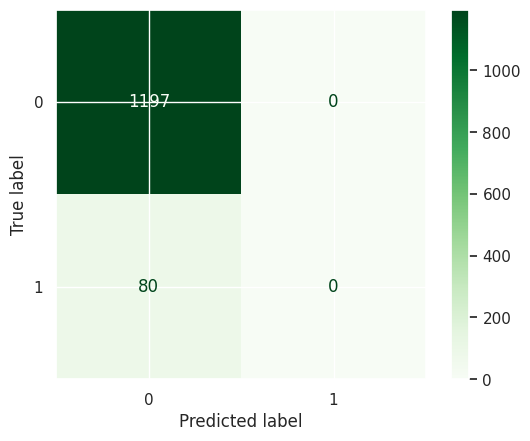

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
tuned_rftest_scores = eval_classification(y_test, rf_gstest_preds, name='Hypertuned Test Random Forest')

#Logistic Regression Model

In [73]:
lr = LogisticRegression(max_iter=1000)

In [74]:
logreg_pipe = make_pipeline(prepro, lr)

In [75]:
logreg_pipe.fit(X_train, y_train) 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9d7e7f0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9c7fc70>)])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [76]:
logreg_train_preds = logreg_pipe.predict(X_train)
log_reg_test_preds = logreg_pipe.predict(X_test)

Logistic Regression Train Score 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3659
           1       0.00      0.00      0.00       169

    accuracy                           0.96      3828
   macro avg       0.48      0.50      0.49      3828
weighted avg       0.91      0.96      0.93      3828



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


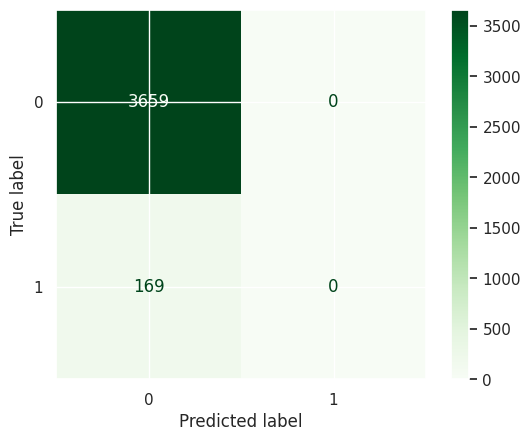

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
logreg_train_scores = eval_classification(y_train, logreg_train_preds, name='Logistic Regression Train Score')

Logistic Regression Tsst Score 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1197
           1       1.00      0.01      0.02        80

    accuracy                           0.94      1277
   macro avg       0.97      0.51      0.50      1277
weighted avg       0.94      0.94      0.91      1277



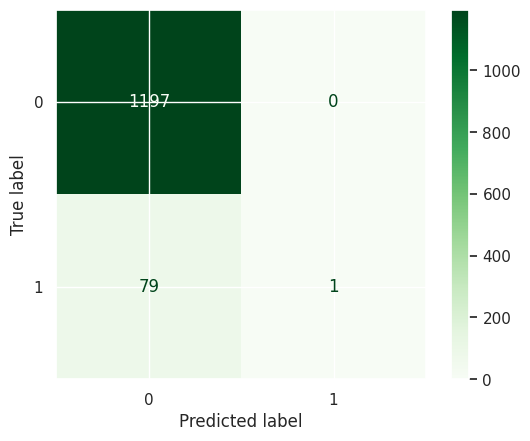

In [78]:
logreg_test_scores = eval_classification(y_test, log_reg_test_preds, name='Logistic Regression Tsst Score')

Does a great job predicting who has not had a stroke and does not have any false positives.  However, it is not very good at predicting who has had a stroke and has a higher false negatives than true positives.  Just like the last models.

In [79]:
logreg_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9d7e7f0>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9c7fc70>)])),
  ('logisticregression', LogisticRegression(max_iter=1000))],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9d7e7f0>),
                                 ('onehotencoder'

In [80]:
log_params = {'logisticregression__C': np.logspace(-3, 3, 7),
                   'logisticregression__penalty': ["l1","l2"],
                    'logisticregression__max_iter':[1000, 2000, 3000]}

In [81]:
logreg_gs = GridSearchCV(logreg_pipe, log_params, cv=5)

In [82]:
logreg_gs.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
105 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9d7e7f0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9c7fc70>)])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'logisticregression__max_iter': [1000, 2000, 3000],
                         'logisticregression__penalty': ['l1', 'l2']})

In [83]:
logreg_gs.best_params_

{'logisticregression__C': 0.001,
 'logisticregression__max_iter': 1000,
 'logisticregression__penalty': 'l2'}

In [84]:
logreg_best = logreg_gs.best_estimator_

In [85]:
logregtrain_predstuned = logreg_best.predict(X_train)
logregtest_predstuned = logreg_best.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hypertuned Logreg Train Scores 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3659
           1       0.00      0.00      0.00       169

    accuracy                           0.96      3828
   macro avg       0.48      0.50      0.49      3828
weighted avg       0.91      0.96      0.93      3828



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


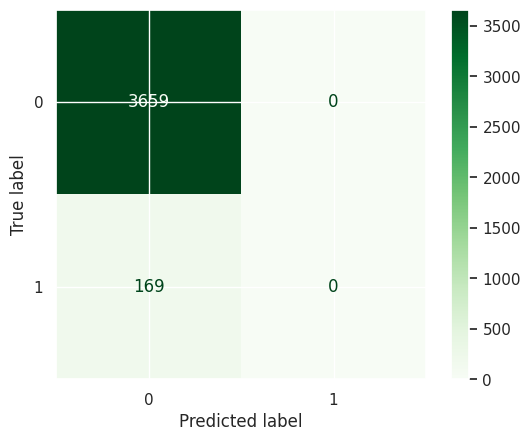

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
tuned_logreg_trainscores = eval_classification(y_train, logregtrain_predstuned, name='Hypertuned Logreg Train Scores')

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hypertuned Logreg Test Scores 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1197
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1277
   macro avg       0.47      0.50      0.48      1277
weighted avg       0.88      0.94      0.91      1277



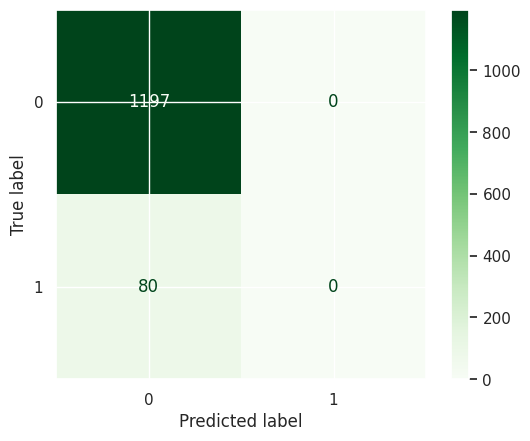

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
tuned_logreg_testscores = eval_classification(y_test, logregtest_predstuned, name='Hypertuned Logreg Test Scores')

# Just like the other models, it does really well predicting who has not had a stroke, but unable to predict someone that has had one.

# Weighted Logistic Regression

In [88]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [89]:
over_sampler = RandomOverSampler()
over_sample_pipe = make_sampler_pipeline(prepro, over_sampler)

In [90]:
X_train_over, y_train_over = over_sample_pipe.fit_resample(X_train, y_train)

In [91]:
print('Original X_train class balance')
print(y_train.value_counts())
print('\nOversampled X_train_over class balance')
y_train_over = pd.Series(y_train_over)
print(y_train_over.value_counts())

Original X_train class balance
0    3659
1     169
Name: stroke, dtype: int64

Oversampled X_train_over class balance
0    3659
1    3659
Name: stroke, dtype: int64


In [92]:
log_reg_over= LogisticRegression(max_iter=1000, solver='lbfgs')

In [93]:
over_sample_log_reg_pipe = make_sampler_pipeline(prepro, over_sampler, log_reg_over)

In [94]:
over_sample_log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9d7e7f0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9c7fc70>)])),
                ('randomoversampler', RandomOverSampler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [95]:
oversample_trainpreds = over_sample_log_reg_pipe.predict(X_train)

In [96]:
oversample_testpreds = over_sample_log_reg_pipe.predict(X_test)

OverSample Train Scores 

              precision    recall  f1-score   support

           0       0.99      0.75      0.85      3659
           1       0.13      0.85      0.23       169

    accuracy                           0.75      3828
   macro avg       0.56      0.80      0.54      3828
weighted avg       0.95      0.75      0.82      3828



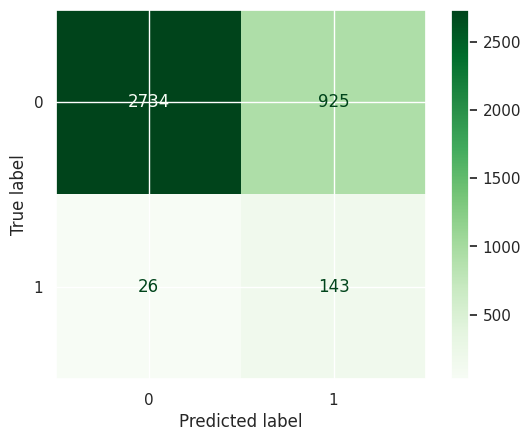

In [97]:
oversampletrainscores = eval_classification(y_train, oversample_trainpreds, name='OverSample Train Scores')

OverSample Test Scores 

              precision    recall  f1-score   support

           0       0.98      0.70      0.82      1197
           1       0.14      0.75      0.24        80

    accuracy                           0.71      1277
   macro avg       0.56      0.73      0.53      1277
weighted avg       0.92      0.71      0.78      1277



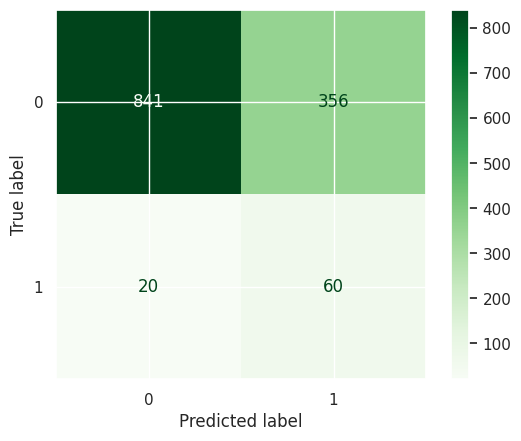

In [98]:
oversampletestscores = eval_classification(y_test, oversample_testpreds, name='OverSample Test Scores')

# SMOTE

In [99]:
smote = SMOTE()
log_reg_smote = LogisticRegression(max_iter=1000)
log_reg_smote_pipe = make_sampler_pipeline(prepro, smote, log_reg_smote)

In [100]:
log_reg_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9d7e7f0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9c7fc70>)])),
                ('smote', SMOTE()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [101]:
smote_trainpreds = log_reg_smote_pipe.predict(X_train)

In [102]:
smote_testpreds = log_reg_smote_pipe.predict(X_test)

SMOTE Train Scores 

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      3659
           1       0.13      0.82      0.23       169

    accuracy                           0.76      3828
   macro avg       0.56      0.79      0.54      3828
weighted avg       0.95      0.76      0.83      3828



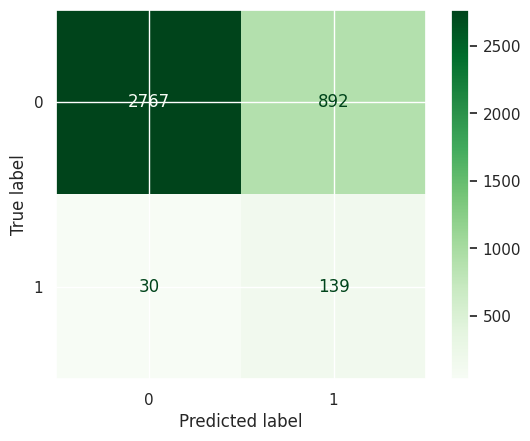

In [103]:
smote_trainscores = eval_classification(y_train, smote_trainpreds, name='SMOTE Train Scores')

SMOTE Test Scores 

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      1197
           1       0.15      0.74      0.25        80

    accuracy                           0.72      1277
   macro avg       0.56      0.73      0.54      1277
weighted avg       0.92      0.72      0.79      1277



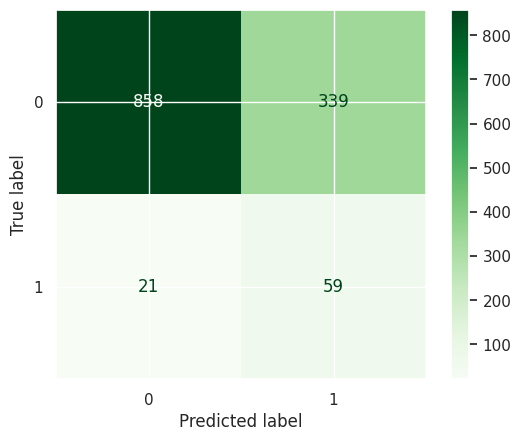

In [104]:
smote_testscores = eval_classification(y_test, smote_testpreds, name='SMOTE Test Scores')

In [105]:
accuracysmote = accuracy_score(y_test, smote_testpreds)

In [106]:
accuracysmote

0.7180892717306187

In [107]:
accuracy= accuracy_score(y_test, rf_testpreds)

In [108]:
accuracy

0.9365700861393892

# PCA

In [109]:
df['gender'] = df['gender'].map({'M':1, F})
X.shape

(5105, 8)

In [111]:
pca = PCA()

In [113]:
scaler = StandardScaler()

In [117]:
dfscaled_X = prepro.fit_transform(X)

In [118]:
pca.fit(dfscaled_X)

PCA()

In [119]:
pd.Series(pca.explained_variance_ratio_).cumsum().sort_values(ascending=False).head(50)

9     1.000000
10    1.000000
11    1.000000
12    1.000000
8     0.976104
7     0.948235
6     0.903270
5     0.832913
4     0.758343
3     0.670194
2     0.547307
1     0.420952
0     0.274655
dtype: float64

<ipython-input-120-b208d9f85bc5>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


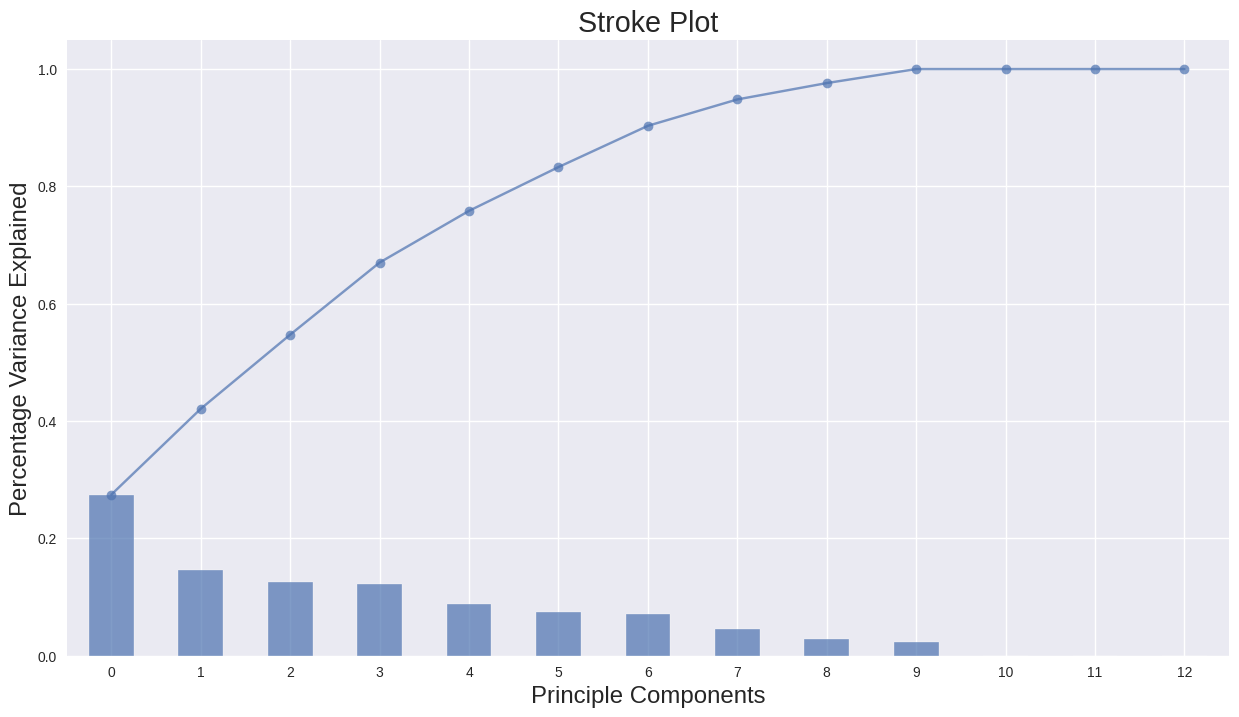

In [120]:
# Lets visual the cummulative sum of the variances 

plt.style.use("seaborn")
plt.figure(figsize=(15,8))
exp_var = pd.Series(pca.explained_variance_ratio_)

# Plot the variance for each component
exp_var.plot(kind="bar", alpha=0.7) # plot bar chart

# Calculate the amount of variance explained added by each additional component
total = 0
var_ls = []
for x in exp_var:
    total = total+x
    var_ls.append(total)
    
# Plot line chart of increasing variances
pd.Series(var_ls).plot(marker="o", alpha=0.7) 

# Plot labels and titles
plt.xlabel("Principle Components", fontsize="x-large")
plt.ylabel("Percentage Variance Explained", fontsize="x-large")
plt.title("Stroke Plot", fontsize="xx-large")
plt.show();

## Going to use plot 6.  Keeps 90% of the data.

In [121]:
transformer = make_pipeline(prepro, PCA(n_components=6))

In [122]:
logreg_pca = make_pipeline(transformer, lr)

In [123]:
logreg_pca.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('standardscaler',
                                                                   StandardScaler(),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9d7e7f0>),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7faba9c7fc70>)])),
                                 ('pca', PCA(n_components=6))])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [124]:
logreg_pca_trainpreds = logreg_pca.predict(X_train)
logreg_pca_testpreds = logreg_pca.predict(X_test)

Logistic Regression Train Score w/ PCA 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3659
           1       1.00      0.01      0.01       169

    accuracy                           0.96      3828
   macro avg       0.98      0.50      0.49      3828
weighted avg       0.96      0.96      0.93      3828



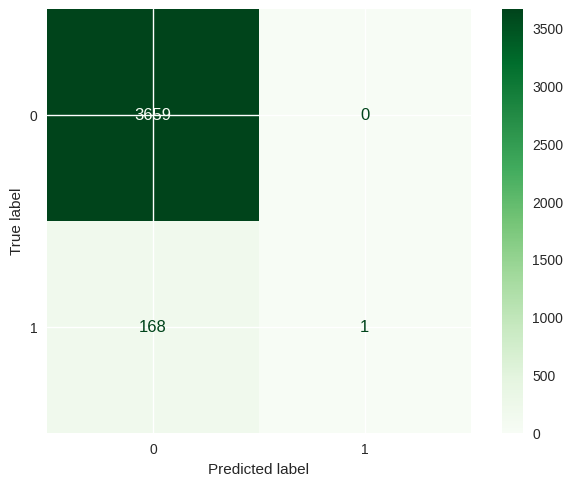

In [125]:
logreg_pca_trainscores = eval_classification(y_train, logreg_pca_trainpreds, name='Logistic Regression Train Score w/ PCA')

Logistic Regression Test Score w/ PCA 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1197
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1277
   macro avg       0.47      0.50      0.48      1277
weighted avg       0.88      0.94      0.91      1277



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


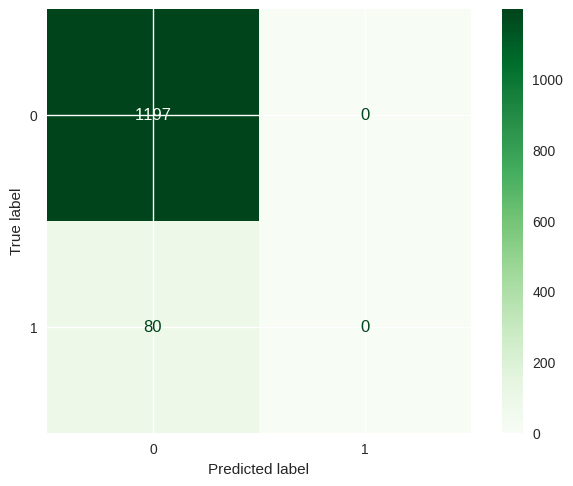

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [126]:
logreg_pca_testscores = eval_classification(y_test, logreg_pca_testpreds, name='Logistic Regression Test Score w/ PCA')

# In Conclusion, I used the SMOTE for the best model, but it would not be a model I would recommend.  It still has too many false negatives.  

1. Source of data
- https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download  StrokePrediction Dataset
2. Brief description of data
- It is used to predict whether a patient is likely to get a stroke based on specific parameteres.  
3. What is the target?
- In the end I think it will be if this person has had a stroke before and possibly be affected by living.
4. What does one row represent? (A person?  A business?  An event? A product?)
 - hypertension- high blood pressure
5. Is this a classification or regression problem?
- classification
6. How many features does the data have?
- 12 features
7. How many rows are in the dataset?
- 5110 rows
8. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?  

- Alot of features could be manipulted in this data set.  I think creating unique columns, making sure I check value counts before I get going.  Also, make sure data types are correct. 